In [1]:
import random
import numpy as np
import matplotlib.pyplot as pyplot
import copy
%matplotlib inline

In [2]:
# パラメータ設定
m = 15
n = 20
rR = 5
cR = 7
k = 5

In [3]:
# カラーバー設定
vmin = 0
vmax = 5

In [4]:
def deal(n, k):
    """
    0, ..., n-1をk個のビンに振り分ける関数．
    それぞれの属するビンを返す
    """
    return [random.choice(range(k)) for i in range(n)]

In [5]:
def make_true(m, n, rR, cR, vals):
    """
    行ランクrR，列ランクcRのk-値m*n行列を作る関数
    """
    table = [[random.choice(vals) for j in range(n)] for i in range(m)]
    row_cat = deal(m, rR)
    col_cat = deal(n, cR)

    return (np.array([[table[row_cat[i]][col_cat[j]] for j in range(n)] for i in range(m)], dtype=float), row_cat, col_cat)

In [18]:
# 真の行列と真のカテゴリをsynth_001_09から読み込む
TM = np.loadtxt("../synth_001_09/TM.mat", delimiter=",")

row_cat = []
with open("../synth_001_09/row_cat", "r") as fin:
    for line in fin:
        row_cat.append(int(line.rstrip()))

col_cat = []
with open("../synth_001_09/col_cat", "r") as fin:
    for line in fin:
        col_cat.append(int(line.rstrip()))

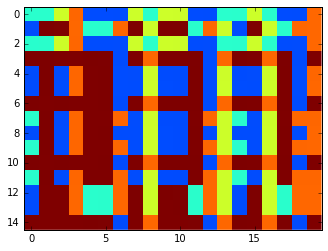

In [19]:
# 真の行列作成
# TM, row_cat, col_cat = make_true(m, n, rR, cR, range(1, k+1))

# 真のカテゴリの保存
with open("row_cat", "w") as fout:
    print("\n".join([str(it) for it in row_cat]), file=fout)
with open("col_cat", "w") as fout:
    print("\n".join([str(it) for it in col_cat]), file=fout)

# TMの保存
np.savetxt("TM.mat", TM, fmt="%i", delimiter=",")

# TMの表示
pyplot.imshow(TM, interpolation="none", vmin=vmin, vmax=vmax)

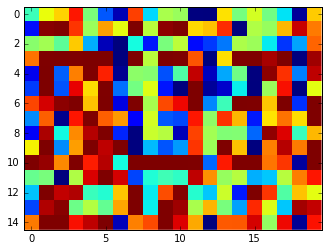

In [20]:
# ノイズを加える
mean = 0
sigma = 1
M_N = TM + np.random.normal(mean, sigma, (m, n))

# M_Nの保存
np.savetxt("M_N.mat", M_N, delimiter=",")

# M_Nの表示
pyplot.imshow(M_N, interpolation="none", vmin=vmin, vmax=vmax)

In [21]:
# マスク行列を作成する関数．確率pで観測
def make_mask(m, n, p):
    retval = np.full((m, n), False, dtype=bool)
    for i in range(m):
        for j in range(n):
            if np.random.binomial(1, p) == 1:
                retval[i, j] = True
    return retval

# マスク関数
def mask(M, A):
    retval = copy.deepcopy(M)
    retval[A == False] = None
    return retval

In [22]:
# マスク行列の作成
p = 0.4
A = make_mask(m, n, p)

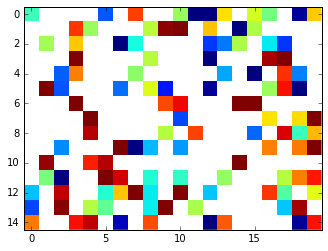

In [23]:
# Mの作成
M = mask(M_N, A)

# Mの保存
np.savetxt("Mnp.mat", M, delimiter=",")

# Mの表示
pyplot.imshow(M, interpolation="none", vmin=vmin, vmax=vmax)

In [24]:
# COO保存関数
def saveCOO(M, fout):
    m, n = M.shape
    for i in range(m):
        for j in range(n):
            if not np.isnan(M[i, j]):
                print(",".join([str(i), str(j), str(M[i, j])]), file=fout)

In [25]:
# Mの平均化
M_mean = np.nanmean(M)
meanedM = M - M_mean

In [26]:
# meanedMのCOO保存
with open("M.mat", "w") as fout:
    saveCOO(meanedM, fout)

In [27]:
# カテゴリ辞書の作成
cat_to_row = {}
for row in range(m):
    cat = row_cat[row]
    if cat not in cat_to_row:
        cat_to_row[cat] = set()
    cat_to_row[cat].add(row)

cat_to_col = {}
for col in range(n):
    cat = col_cat[col]
    if cat not in cat_to_col:
        cat_to_col[cat] = set()
    cat_to_col[cat].add(col)

In [28]:
# グラフラプラシアンの作成
Lr = np.full((m, m), None, dtype=float)
# カテゴリごと
for cat, row_set in cat_to_row.items():
    for row1 in row_set:
        for row2 in row_set:
            if row1 == row2:
                # 対角成分
                Lr[row1, row2] = len(row_set)-1
            else:
                # 非対角成分
                Lr[row1, row2] = -1

Lc = np.full((n, n), None, dtype=float)
# カテゴリごと
for cat, col_set in cat_to_col.items():
    for col1 in col_set:
        for col2 in col_set:
            if col1 == col2:
                # 対角成分
                Lc[col1, col2] = len(col_set)-1
            else:
                # 非対角成分
                Lc[col1, col2] = -1

# グラフラプラシアンの保存
with open("Lr.mat", "w") as fout:
    saveCOO(Lr, fout)
with open("Lc.mat", "w") as fout:
    saveCOO(Lc, fout)

In [38]:
# C++で実行
# import subprocess
# subprocess.run(["../a.out", str(m), str(n), "synth_demo"])

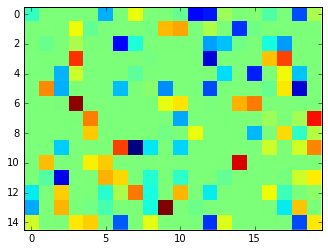

In [39]:
# Xの読込
meaned_X = np.loadtxt("X.mat", delimiter=",")
X = meaned_X + M_mean

# Xの表示
pyplot.imshow(X, interpolation="none", vmin=vmin, vmax=vmax)

In [40]:
# カラースケール
vmin = min((np.min(TM), np.min(X)))
vmax = max((np.max(TM), np.max(X)))

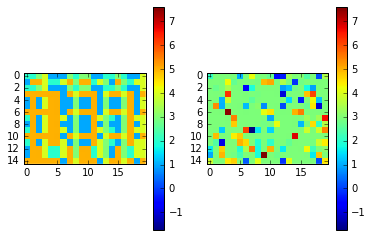

In [41]:
# TMとXの比較
pyplot.subplot(121)
pyplot.imshow(TM, interpolation="none", vmin=vmin, vmax=vmax)
pyplot.colorbar()
pyplot.subplot(122)
pyplot.imshow(X, interpolation="none", vmin=vmin, vmax=vmax)
pyplot.colorbar()

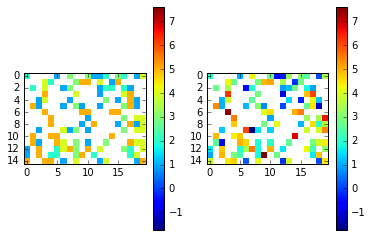

In [42]:
# マスクしたTMとXの比較
pyplot.subplot(121)
pyplot.imshow(mask(TM, A), interpolation="none", vmin=vmin, vmax=vmax)
pyplot.colorbar()
pyplot.subplot(122)
pyplot.imshow(mask(X, A), interpolation="none", vmin=vmin, vmax=vmax)
pyplot.colorbar()